<a href="https://colab.research.google.com/github/hehaoming/Colab/blob/main/ddpm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import  tqdm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

# 位置编码
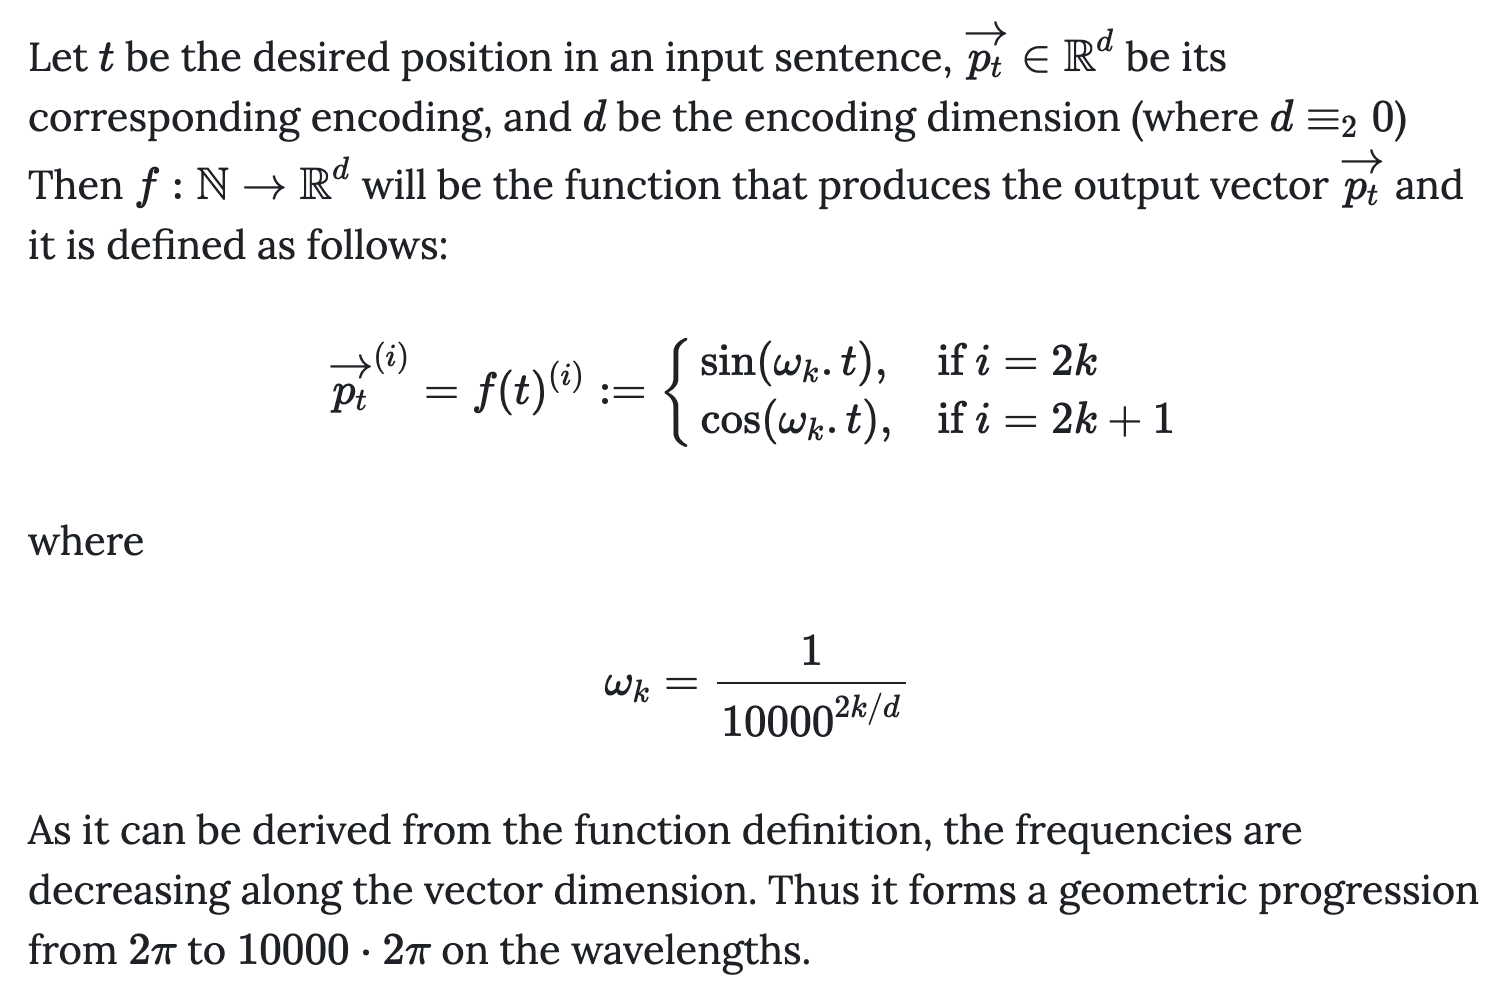

In [ ]:
def timestep_embedding(timesteps, dim, max_period=1000):
    half = dim // 2
    # 不同的函数周期
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(timesteps.device)
    # print(freqs)
    # print(freqs.shape)
    # 不同的位置乘以不同的周期
    args = timesteps[:, None].float() * freqs[None]
    # print(timesteps.shape)
    # print(timesteps[:, None])
    # print(freqs[None])
    # print(args)
    # sin 和 cos 编码
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    # print(embedding.shape)
    if dim % 2 == 1:
        # 如果dim是奇数，填充一个纬度的0
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [ ]:
te = timestep_embedding(torch.tensor([1, 2, 3]), 5)
print(te.shape)

torch.Size([3, 5])


In [ ]:
class TimestepBlock(nn.Module):

    def forward(self, x, emb):
        pass

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

In [ ]:
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [ ]:
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        h = self.conv1(x)
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B * self.num_heads, -1, H * W).chunk(3, dim=1)
        scale = 1. / math.sqrt(C // self.num_heads)
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = torch.softmax(attn, dim=1)
        h = torch.einsum("bts, bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [ ]:
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [ ]:
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)),
        ])
        down_block_chans = [model_channels, ]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(self.channel_mult):
            for _ in range(num_res_blocks):
                layer = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout=dropout),
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layer.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layer))
                down_block_chans.append(ch)
            if level != len(channel_mult) -1:
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layer = [
                    ResidualBlock(ch + down_block_chans.pop(), model_channels * mult, time_embed_dim, dropout),
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layer.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layer.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layer))
        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        hs = []
        # time step embedding
        emb = self.time_embed(
            timestep_embedding(timesteps, self.model_channels)
        )
        h = x
        # down stage
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [ ]:
unet = UNetModel()
unet

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_emb): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (conv2): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (shortcut): Identi

In [ ]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

In [ ]:
linear_beta_schedule(1000)

tensor([0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0017, 0.0017, 0.0017,
        0.0017, 0.0017, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0023, 0.0023, 0.0023, 0.0023, 

In [ ]:
class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_schedule='linear'):
        self.timesteps = timesteps

        if beta_schedule == "linear":
            betas = linear_beta_schedule(timesteps)
        # elif beta_schedule == "cosine":
            # betas = consin_beta_schedule(timesteps)
        else:
            raise ValueError(f"unknown beta schedule {beta_schedule}")
        self.betas = betas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        # 在最前方补 1 把其他的搜往后移动一位, 从最后一个纬度开始，(1, 0) 表示在这个维度的前和后 pad 的长度
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # calculations for diffusion q(x_t|x_{t - 1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        # 保持跟 x_start 一样的维度个数，补了好几个 1 的维度
        out = out.reshape(batch_size, *((1, ) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    # 前向过程 从 x_0 得到 x_t
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0)
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [ ]:
batch_size = 256
timesteps = 1000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=128,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

100%|██████████| 9912422/9912422 [00:00<00:00, 90799262.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36009421.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25801232.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17009400.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# train
# epochs = 20

# for epoch in range(epochs):
#     losses = []
#     for step, (images, labels) in tqdm(enumerate(train_loader)):
#         optimizer.zero_grad()

#         batch_size = images.shape[0]
#         images = images.to(device)

#         # sample t uniformally for every example in the batch
#         t = torch.randint(0, timesteps, (batch_size,), device=device).long()

#         loss = gaussian_diffusion.train_losses(model, images, t)
#         losses.append(loss)
#         loss.backward()
#         optimizer.step()

#     checkpoint = {
#         "model": model.state_dict(),
#         "optimizer": optimizer.state_dict(),
#         "epoch": epoch,
#     }
#     torch.save(checkpoint, f"models/model_{epoch}.pth")
#     torch.save(checkpoint, f"models/checkpoint.pth")
#     print(f"Epoch: [{epoch}], loss: {sum(losses) / len(losses)}")

In [ ]:
# 235it [01:20,  2.93it/s]
# [Epoch: 0]--loss: 0.0698896199464798
# 235it [01:15,  3.12it/s]
# [Epoch: 1]--loss: 0.029479287564754486
# 235it [01:15,  3.12it/s]
# [Epoch: 2]--loss: 0.026447905227541924
# 235it [01:15,  3.11it/s]
# [Epoch: 3]--loss: 0.02529257908463478
# 235it [01:15,  3.11it/s]
# [Epoch: 4]--loss: 0.02427246980369091
# 235it [01:15,  3.11it/s]
# [Epoch: 5]--loss: 0.02395142801105976
# 235it [01:15,  3.11it/s]
# [Epoch: 6]--loss: 0.02344534732401371
# 235it [01:15,  3.11it/s]
# [Epoch: 7]--loss: 0.023512449115514755
# 235it [01:15,  3.11it/s]
# [Epoch: 8]--loss: 0.02300390787422657
# 235it [01:15,  3.11it/s]
# [Epoch: 9]--loss: 0.022760486230254173
# 235it [01:15,  3.11it/s]
# [Epoch: 10]--loss: 0.02270420268177986
# 235it [01:15,  3.11it/s]
# [Epoch: 11]--loss: 0.022445829585194588
# 235it [01:15,  3.11it/s]
# [Epoch: 12]--loss: 0.022315990179777145
# 235it [01:15,  3.11it/s]
# [Epoch: 13]--loss: 0.022336836904287338
# 235it [01:15,  3.11it/s]
# [Epoch: 14]--loss: 0.02219557948410511
# 235it [01:15,  3.11it/s]
# [Epoch: 15]--loss: 0.022078149020671844
# 235it [01:15,  3.11it/s]
# [Epoch: 16]--loss: 0.022046666592359543
# 235it [01:15,  3.11it/s]
# [Epoch: 17]--loss: 0.021991580724716187
# 235it [01:15,  3.11it/s]
# [Epoch: 18]--loss: 0.021959364414215088
# 235it [01:15,  3.11it/s]
# [Epoch: 19]--loss: 0.02181519754230976
# 235it [01:15,  3.11it/s]
# [Epoch: 20]--loss: 0.021818019449710846
# 235it [01:15,  3.11it/s]
# [Epoch: 21]--loss: 0.021733425557613373
# 235it [01:15,  3.11it/s]
# [Epoch: 22]--loss: 0.021648185327649117
# 235it [01:15,  3.11it/s]
# [Epoch: 23]--loss: 0.02174585498869419
# 235it [01:15,  3.11it/s]
# [Epoch: 24]--loss: 0.021573275327682495
# 235it [01:15,  3.11it/s]
# [Epoch: 25]--loss: 0.022020140662789345
# 235it [01:15,  3.11it/s]
# [Epoch: 26]--loss: 0.021672379225492477
# 235it [01:15,  3.11it/s]
# [Epoch: 27]--loss: 0.021523723378777504
# 235it [01:15,  3.11it/s]
# [Epoch: 28]--loss: 0.021340608596801758
# 235it [01:15,  3.11it/s]
# [Epoch: 29]--loss: 0.021639693528413773
# 235it [01:15,  3.11it/s]
# [Epoch: 30]--loss: 0.02141735889017582
# 235it [01:15,  3.11it/s]
# [Epoch: 31]--loss: 0.021459588780999184
# 235it [01:15,  3.11it/s]
# [Epoch: 32]--loss: 0.021319445222616196
# 235it [01:15,  3.11it/s]
# [Epoch: 33]--loss: 0.021483954042196274
# 235it [01:15,  3.11it/s]
# [Epoch: 34]--loss: 0.021425889804959297
# 235it [01:15,  3.11it/s]
# [Epoch: 35]--loss: 0.021261876448988914
# 235it [01:15,  3.11it/s]
# [Epoch: 36]--loss: 0.021298294886946678
# 235it [01:15,  3.11it/s]
# [Epoch: 37]--loss: 0.021253539249300957
# 235it [01:15,  3.11it/s]
# [Epoch: 38]--loss: 0.02134215459227562
# 235it [01:15,  3.11it/s]
# [Epoch: 39]--loss: 0.021372469142079353
# 235it [01:15,  3.11it/s]
# [Epoch: 40]--loss: 0.02108888141810894
# 235it [01:15,  3.11it/s]
# [Epoch: 41]--loss: 0.02116216905415058
# 235it [01:15,  3.11it/s]
# [Epoch: 42]--loss: 0.02126198448240757
# 235it [01:15,  3.11it/s]
# [Epoch: 43]--loss: 0.02093162201344967
# 235it [01:15,  3.11it/s]
# [Epoch: 44]--loss: 0.021006492897868156
# 235it [01:15,  3.11it/s]
# [Epoch: 45]--loss: 0.02093612588942051
# 235it [01:15,  3.11it/s]
# [Epoch: 46]--loss: 0.020730458199977875
# 235it [01:15,  3.11it/s]
# [Epoch: 47]--loss: 0.021017014980316162
# 235it [01:15,  3.11it/s]
# [Epoch: 48]--loss: 0.020749403163790703
# 235it [01:15,  3.11it/s]
# [Epoch: 49]--loss: 0.020759930834174156

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/model_48_mnist.pth", map_location="cuda")
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [ ]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

sampling loop time step: 100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]


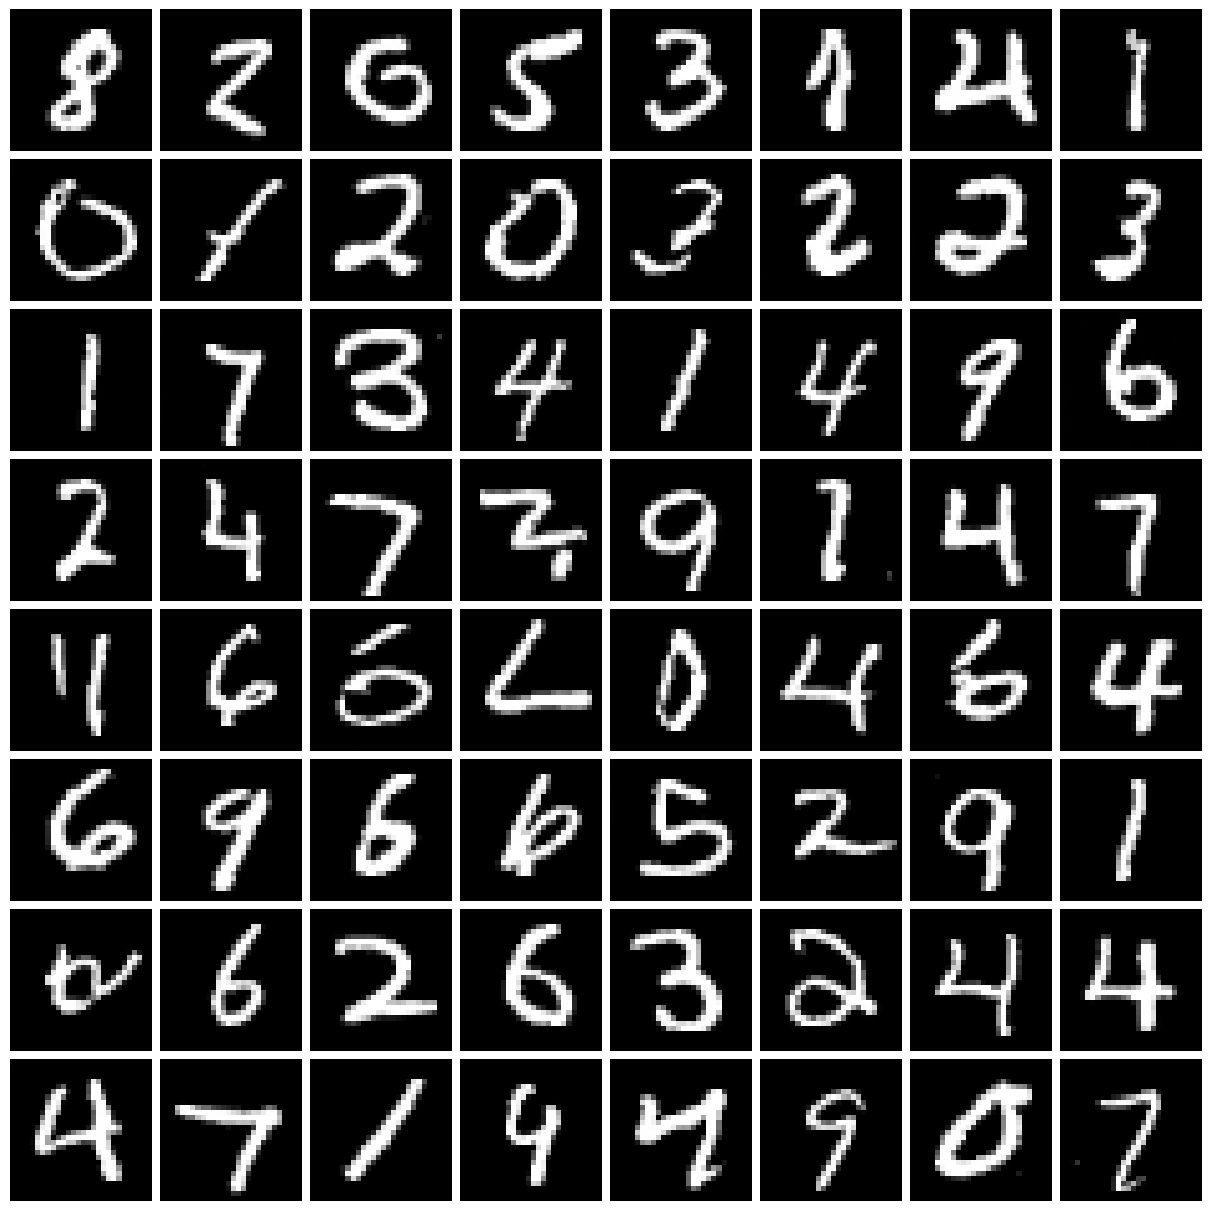

In [ ]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col] + 1.0) / 2, cmap="gray")
        f_ax.axis("off")

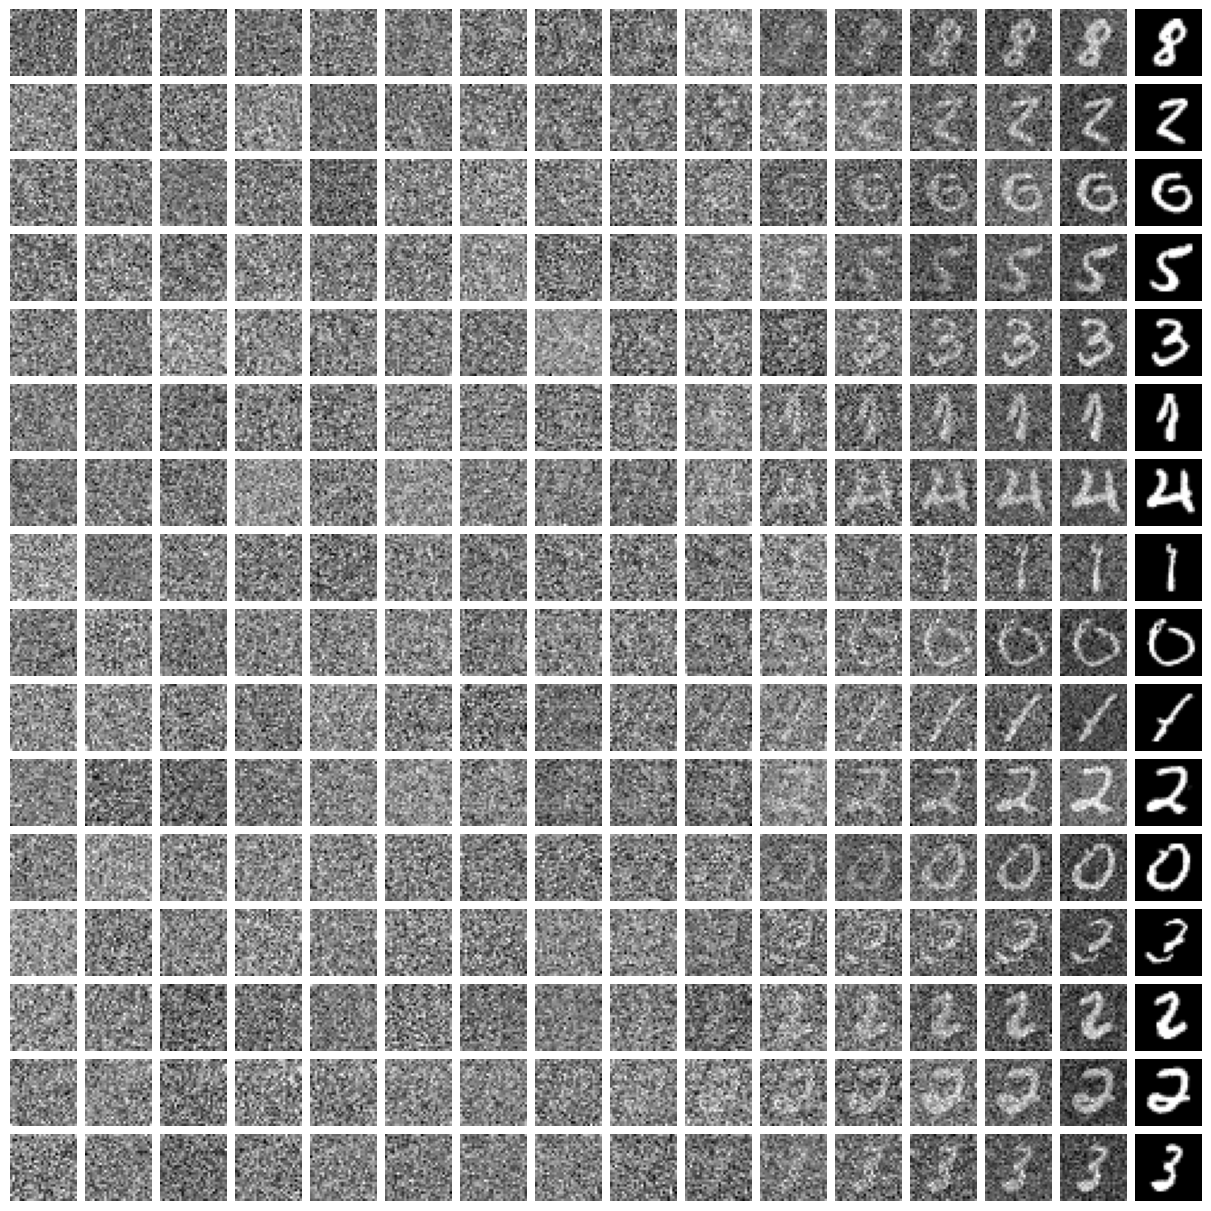

In [ ]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")